In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

In [23]:
device = 'cuda'

# Finetuning

## AG News

In [24]:
train_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=4000)

test_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'test')

In [25]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [26]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",  
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Understanding layer names

In [30]:
batch_size = 32

In [31]:
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [32]:
attentions = []
all_tokens = []
val_accuracy = []
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
n_epochs = 100

y_pred_val = torch.Tensor([])
y_val = torch.Tensor([])

best_acc = 0
best_model = None

for epoch in range(n_epochs):
    with torch.no_grad():
        for row in tqdm(val_dataloader):

            tokens = tokenizer(
                row['text'], 
                return_tensors='pt',
                padding = 'longest'
            )

            out = model(**tokens.to(device), labels = torch.tensor(row['label'], device= device))
            pred = out.logits.argmax(dim = 1).to("cpu")

            y_pred_val = torch.concat([pred, y_pred_val])
            y_val = torch.concat([torch.Tensor(row['label']), y_val])

        accuracy = (y_pred_val == y_val).to(torch.float).mean()

        clear_output()
        print(f"Epoch {epoch}: {accuracy}")
        if accuracy > best_acc:
            best_acc = accuracy
            best_model = deepcopy(model)

        val_accuracy.append(accuracy)
            
    for row in tqdm(train_dataloader):
        optimizer.zero_grad()

        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        out = model(**tokens.to(device), labels = torch.tensor(row['label'], device= device))
        
        loss = out.loss
        loss.backward()

        optimizer.step()


best_model.push_to_hub("peulsilva/bert-ag_news")

Epoch 99: 0.8909500241279602


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:22<00:00,  5.53it/s]


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/bert-ag_news/commit/b73e90a04dc96a7446d6ecd9d4fb82ff98eeebe6', commit_message='Upload BertForSequenceClassification', commit_description='', oid='b73e90a04dc96a7446d6ecd9d4fb82ff98eeebe6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/peulsilva/bert-ag_news', endpoint='https://huggingface.co', repo_type='model', repo_id='peulsilva/bert-ag_news'), pr_revision=None, pr_num=None)

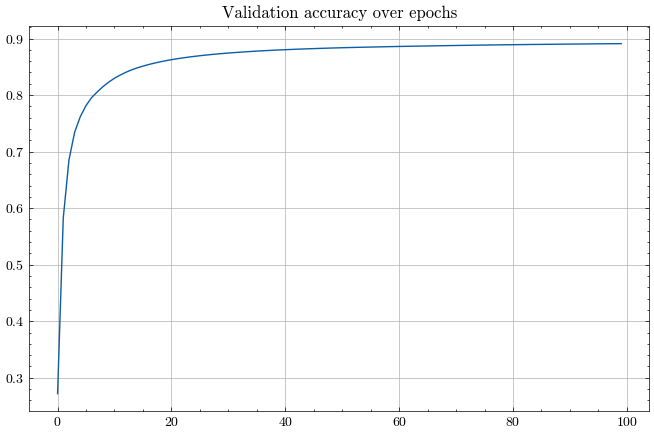

In [38]:
plt.figure( figsize = (8,5))
plt.plot(val_accuracy,)
plt.title("Validation accuracy over epochs")
plt.grid()